In [1]:
%run "part01_preprocessing.ipynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   Unnamed: 8   0 non-null       float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


# Statatistical Quartile Model

In [2]:
from IPython.display import HTML
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
rfm = transactions_per_customer.copy()

In [4]:
r_labels = range(5, 0, -1)
f_labels = range(1, 6, 1)
m_labels = range(1, 10, 1)

rfm["R"] = pd.qcut(rfm["Recency"], 5, labels = r_labels)
rfm["F"] = pd.qcut(rfm["Frequency"].rank(method = 'first'), 5, labels = f_labels)
rfm["M"] = pd.qcut(rfm["GrossRevenue"], 9, labels = m_labels)

rfm.sample(10)

,GrossRevenue,Recency,Frequency,Products,Items,Country,R,F,M
CustomerID,,,,,,,,,
14499,815.32,27,3,182,501,United Kingdom,4,3,6
12866,499.12,284,1,25,167,Belgium,1,1,4
13954,378.59,2,3,30,141,United Kingdom,5,3,3
13631,3021.77,100,12,12,460,United Kingdom,2,5,8
17337,1942.87,152,7,508,1239,United Kingdom,2,5,8
15146,1313.66,165,3,95,1459,United Kingdom,2,3,7
15120,343.82,130,2,22,292,United Kingdom,2,2,3
15258,623.16,169,2,34,142,United Kingdom,2,2,5
14515,2102.09,18,6,98,1134,United Kingdom,4,4,8


In [5]:
rfm["RFM"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)
rfm["Score"] = rfm[["R", "F", "M"]].sum(axis = 1)

In [6]:
segt_map = {
    r'[1-2][1-2][1-9]': 'Hinernating',
    r'[1-2][3-4][1-9]': 'At Risk',
    r'[1-2]5[1-9]': 'Cannot Lose Them',
    r'3[1-2][1-9]': 'About to Sleep',
    r'33[1-9]': 'Need Attention',
    r'[3-4][4-5][1-9]': 'Loyal Customers',
    r'41[1-9]': 'Promising',
    r'51[1-9]': 'New Customers',
    r'[4-5][2-3][1-9]': 'Potential Loyalists',
    r'5[4-5][1-9]': 'Champions'
}

rfm['Segment'] = rfm['RFM'].replace(segt_map, regex=True)
#rfm['RFM'] = rfm['R'].astype(str) + rfm['F'].astype(str) 
rfm.head()

,GrossRevenue,Recency,Frequency,Products,Items,Country,R,F,M,RFM,Score,Segment
CustomerID,,,,,,,,,,,,
12347,4310.00,3,7,182,2458,Iceland,5,4,9,549,18,Champions
12348,1437.24,76,4,23,2332,Finland,2,3,7,237,12,At Risk
12349,1457.55,19,1,72,630,Italy,4,1,7,417,12,Promising
12350,294.40,311,1,16,196,Norway,1,1,3,113,5,Hinernating
12352,1265.41,37,8,84,463,Norway,3,5,7,357,15,Loyal Customers


In [7]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot Lose Them": [4, 5, 0, 0.4],
                   "At Risk": [2, 4, 0, 0.4],
                   "Hinernating": [0, 2, 0, 0.4],
                   "About to Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

In [8]:
report = rfm[['GrossRevenue','Recency','Frequency','RFM','Segment']].groupby('Segment').agg( MonetarySum = ('GrossRevenue', 'sum'),
                                             MonetaryMean = ('GrossRevenue', 'mean'),
                                             Recency = ('Recency', 'mean'),
                                             Frequency = ('Frequency', 'mean'),
                                             Count = ('GrossRevenue', 'count')).reset_index()

report['Percentage'] = round((report['Count'] / report['Count'].sum()*100),2)
report.set_index('Segment',inplace=True)
report = report.sort_values("MonetaryMean", ascending = False)

In [9]:
cm = sns.light_palette("#A2A2A2", as_cmap = True)

report=report.style.background_gradient(cmap = cm, axis = 0)\
    .set_precision(2)\
    .highlight_min(axis = 0, color = "#FF6347")\
    .highlight_max(axis = 0, color = "#2F4F4F")

report

,MonetarySum,MonetaryMean,Recency,Frequency,Count,Percentage
Segment,,,,,,
Champions,4297841.74,6521.76,6.07,14.40,659,15.28
Loyal Customers,2116917.80,2717.48,32.66,7.89,779,18.07
Cannot Lose Them,163259.70,2366.08,133.39,9.70,69,1.60
At Risk,604910.58,1020.09,155.67,3.33,593,13.75
Need Attention,150999.98,811.83,49.26,2.63,186,4.31
Potential Loyalists,336784.95,690.13,16.59,2.22,488,11.32
About to Sleep,152843.38,432.98,52.36,1.27,353,8.19
Hinernating,420963.68,402.84,213.80,1.21,1045,24.23
New Customers,15428.84,367.35,7.24,1.00,42,0.97


In [10]:
di.export(report,'../images/rfm_statistic_table.png')

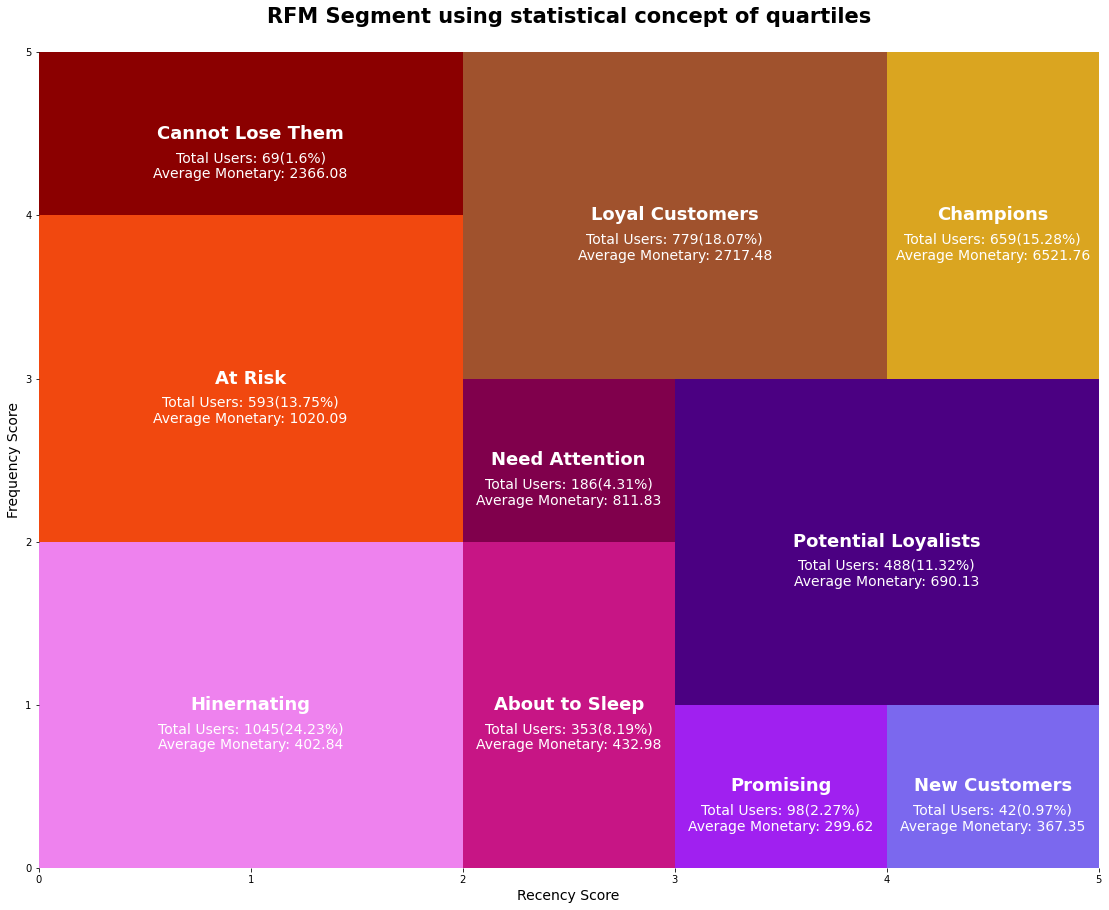

In [11]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"

palette = ["#DAA520", "#A0522D", "#8B0000", "#F1480F",  "#EE82EE", 
           "#C71585", "#A020F0", "#7B68EE", "#4B0082", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm[rfm.Segment == key].shape[0]
    users_percentage = (rfm[rfm.Segment == key].shape[0] / rfm.shape[0]) * 100
    avg_monetary = rfm[rfm.Segment == key]["GrossRevenue"].mean()
    
    user_txt = "\n\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score", fontsize=14)
    ax.set_ylabel("Frequency Score", fontsize=14)
    
sns.despine(left = True, bottom = True)

plt.title('RFM Segment using statistical concept of quartiles\n', fontsize='21', fontweight='bold')
plt.savefig("..//images//rfm_statistic.png")
plt.show()